# Free Recall

In [30]:
import math

def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (float('nan'), float('nan'))
    p = k / n
    denom = 1 + (z**2) / n
    center = (p + (z**2) / (2 * n)) / denom
    half_width = (z * math.sqrt((p * (1 - p) + (z**2) / (4 * n)) / n)) / denom
    return (center - half_width, center + half_width)

Read all files (trials) in the specified folder and for each of them calculate the number of correct guesses and the corresponding flags (1 in the position of samples correctly guessed in any position).

In [31]:
import pandas as pd
from pathlib import Path

base = Path('..') / 'data' / 'free'
results = []

for trial in sorted(base.glob('*.csv')):
    df = pd.read_csv(trial)
    guesses = set(df['guess'].dropna().astype(str))  # set of unique guesses (no repetition)
    samples = df['sample'].astype(str)

    # binary vector: 1 if sample appears anywhere in guesses, else 0
    binaries = [1 if s in guesses else 0 for s in samples]

    # total correct is sum of binaries
    total_correct = sum(binaries)

    results.append({
        'file': str(trial),
        'counts': total_correct,
        'binaries': binaries
    })

Computes per-trial and overall summary statistics (mean, population variance, overall proportion and Wilson 95% CI) of correct guesses, prints them, and plots a bar chart of correct recalls by serial position (1–20).

Trials: 20
Mean correct guesses (per trial): 6.500
Wilson CI (95%): (0.2810, 0.3724)


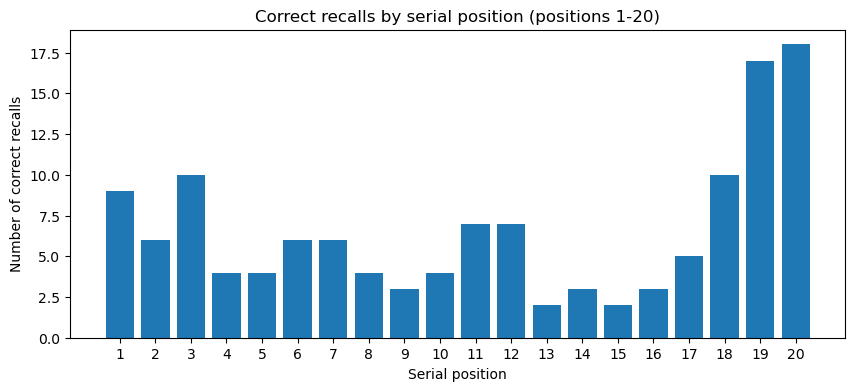

In [32]:
counts = [r['counts'] for r in results]
n_trials = len(counts)
mean_counts = sum(counts) / n_trials
var_counts = sum((x - mean_counts) ** 2 for x in counts) / n_trials  # population variance

total_successes = sum(r['counts'] for r in results)
total_positions = sum(len(r['binaries']) for r in results)
proportion = total_successes / total_positions if total_positions > 0 else float('nan')
ci_low, ci_high = wilson_ci(total_successes, total_positions)

print(f"Trials: {n_trials}")
print(f"Mean correct guesses (per trial): {mean_counts:.3f}")
print(f"Wilson CI (95%): ({ci_low:.4f}, {ci_high:.4f})")


# Compute counts for positions 1..20 (index 0..19)
pos_counts = [0]*20
for r in results:
    bins = r['binaries']
    for i in range(min(20, len(bins))):
        pos_counts[i] += int(bins[i])

positions = list(range(1,21))
plt.figure(figsize=(10,4))
plt.bar(positions, pos_counts)
plt.xlabel('Serial position')
plt.ylabel('Number of correct recalls')
plt.xticks(positions)
plt.title('Correct recalls by serial position (positions 1-20)')
plt.show()